# Lecture 10: Predictive Modeling: Classification

## Contents

- [Imports](#section1)
- [Introduction to classification](#section2) 
- [Logistic regression](#section3)
    - [Logistic function](#subsection3.1)
    - [Cross-validation for assessing model performance](#subsection3.2)
- [Linear discriminant analysis](#section4)
- [Quadratic discriminant analysis](#section5)
- [Support vector machines](#section6)
    - [Maximal margin classifier for well separated classes](#subsection6.1)
    - [Support vector classifier](#subsection6.2)
    - [Support vector machine classifier](#subsection6.3)
- [K-nearest neighbor classification](#section7)
- [Case studies](#section8)
    - [Case study 1: Bank marketing](#subsection8.1)

## Imports <a id="section1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd

pd.set_option("display.max_columns", 10, 
              "display.max_rows", 7)                    # Diaply configuration of Pandas data frame

from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV        
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [2]:
import os
os.chdir('/Users/Xinwei/Desktop/BMK5202 Py for BA/Dataset')

## Introduction to classification<a id="section2"></a>

> *We now turn our focus to building and evaluating models for a categorical response. Although many of the regression modeling techniques can also be used for classification, the way we evaluate model performance is necessarily very different since metrics like RMSE and $R^2$ are not appropriate in the context of classification.* - [Applied Predictive Modeling](https://vuquangnguyen2016.files.wordpress.com/2018/03/applied-predictive-modeling-max-kuhn-kjell-johnson_1518.pdf)

Examples of classification problems:
- A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?
- An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth.
- On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

## Logistic regression <a id="section3"></a>

> *Classification models usually generate two types of predictions. Like regression models, classification models produce a continuous valued prediction, which is usually in the form of a probability (i.e., the predicted values of class membership for any individual sample are between 0 and 1 and sum to 1). In addition to a continuous prediction, classification models generate a predicted class, which comes in the form of a discrete category.* - [Applied Predictive Modeling](https://vuquangnguyen2016.files.wordpress.com/2018/03/applied-predictive-modeling-max-kuhn-kjell-johnson_1518.pdf)

In this section, we will use a logistic regression model to explain the basic concepts of classification, such as:
- How to produce a continuous prediction as the probability;
- How to determine the predicted class based on the probability value;
- How to assess the performance of a classification model.

<div class="alert alert-block alert-success">
<b>Example 1:</b>  
    Consider the credit card default dataset "default.csv", where the response <b>default</b> falls into one of two categories, "Yes" or "No". Try to predict the status of <b>default</b> using the predictor variable <b>balance</b>.
</div>

The dataset "default.csv" is imported and the categorical variables are converted into dummies by the following code cell. The categorical response <code>default</code> is converted into the dummy variable <code>default_Yes</code>.

In [2]:
credit = pd.read_csv('default.csv')
credit_num = pd.get_dummies(credit, drop_first=True)
credit_num

,balance,income,default_Yes,student_Yes
0,729.526495,44361.62507,0,0
1,817.180407,12106.13470,0,1
2,1073.549164,31767.13895,0,0
...,...,...,...,...
9997,845.411989,58636.15698,0,0
9998,1569.009053,36669.11236,0,0
9999,200.922183,16862.95232,0,1


The dummy variable <code>default_Yes</code> equals one for default ("Yes"), and zero for not default ("No"), so it is natural to take anything between zero and one as the probability of default. 

### Logistic function <a id="subsection3.1"></a>

According to the interpretation above, we will first try a linear regression model
$$
y_{\text{prob}} = \beta_0 + \beta_1 x_{\text{balance}}
$$
for fitting the probability value. The results are given below (Figure 4.2 on page 131 of the reference book [An Introduction to Statistical Learning-with Applications in R](https://web.stanford.edu/~hastie/ISLRv2_website.pdf)).

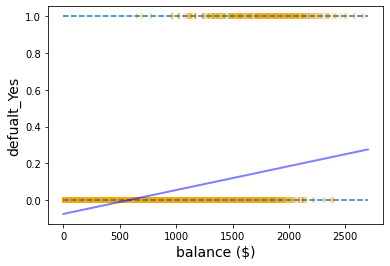

In [3]:
x = credit_num[['balance']]
y = credit_num['default_Yes']

regr = LinearRegression() 
regr.fit(x, y)                                          # Fitting the LR model with x, y training data    
x_pred = np.arange(0, 2701).reshape((2701, 1))          # New x values to be predicted
y_pred = regr.predict(x_pred)                           # Predicted y values

plt.hlines(1, xmin=0, xmax=2700, linestyle='--')        # False-level horizontal line
plt.hlines(0, xmin=0, xmax=2700, linestyle='--')        # True-level horizontal line
plt.scatter(x, y, marker='|', c='orange', alpha=0.5)    # Scatter points of sample data
plt.plot(x_pred, y_pred,                                # x and y data of the regression curve
         linewidth=2, alpha=0.5, color='b')

plt.xlabel('balance ($)', fontsize=14)
plt.ylabel('defualt_Yes', fontsize=14)
plt.show()

Clearly the linear regression model is not a suitable tool for capturing the probability: for <code>balance</code> values close to zero we predict a negative probability of default; if we were to predict for very large values of <code>balance</code>, we would get values bigger than one. These predictions are not sensible, since of course the true probability of default, regardless of credit card balance, must fall between zero and one. In fact, given the zero-one boundary of the probability, the regression function is unlikely to be linear. 

To avoid this problem, the probability is captured by a **logistic function**, expressed as follows:
$$
y_{\text{prob}} = \frac{\exp\left(\beta_0 + \beta_1 x_{\text{balance}}\right)}{1+\exp\left(\beta_0 + \beta_1 x_{\text{balance}}\right)}.
$$
It can be seen that as the term $\beta_0 + \beta_1 x_{\text{balance}}$ goes to infinity, we have $y_{\text{prob}}$ approaches one, and as it goes to negative infinity, $\exp\left(\beta_0 + \beta_1 x_{\text{balance}}\right)$ goes to zero, thus $y_{\text{prob}}$ approaches zero. By using the logistic function, we could implement the **logistic regression model** which predict the continuous probabilities as follows. 

In [4]:
logit = LogisticRegression() 
logit.fit(x, y)                                         # Fitting the LR model with x, y training data    
x_pred = np.arange(0, 2701).reshape((2701, 1))          # New x values to be predicted
y_proba = logit.predict_proba(x_pred)                   # Predicted probabilities of y being one or zero

Note that `y_proba` is a two-column two-dimensional array, where the first column represent the predicted probability of `default_Yes=0`, and the second column is the predicted probability of `default_Yes=1`. 

In [5]:
y_proba

array([[9.99976331e-01, 2.36688220e-05],
       [9.99976201e-01, 2.37993302e-05],
       [9.99976069e-01, 2.39305581e-05],
       ...,
       [1.49977179e-02, 9.85002282e-01],
       [1.49166999e-02, 9.85083300e-01],
       [1.48361129e-02, 9.85163887e-01]])

It is easy to verify that the summation of probabilities of these two scenarios is one.

In [6]:
y_proba.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

Besides Besides using the `pred_proba()` method to predict the probability of default/not default, we may also use the `predict()` method to determine if predicted value for `default_Yes`. As a default setting of the two-class model, the prediction for `default_Yes` is one if the predicted probability of default is higher than the threshold value 0.5, otherwise the prediction is zero.

In [7]:
y_pred = logit.predict(x_pred)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)

Based on the results, above, we can replicate Figure 4.2 on page 131 of the reference book [An Introduction to Statistical Learning-with Applications in R](https://web.stanford.edu/~hastie/ISLRv2_website.pdf)).

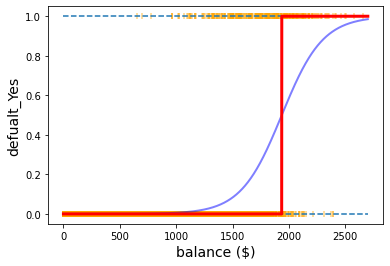

In [8]:
plt.hlines(1, xmin=0, xmax=2700, linestyle='--')        # False-level horizontal line
plt.hlines(0, xmin=0, xmax=2700, linestyle='--')        # True-level horizontal line
plt.scatter(x, y, marker='|', c='orange', alpha=0.5)    # Scatter points of sample data
plt.plot(x_pred, y_proba[:, 1],                         # x and y data of the regression curve
         linewidth=2, alpha=0.5, color='b')
plt.plot(x_pred, y_pred, 
         linewidth=3, color='r')

plt.xlabel('balance ($)', fontsize=14)
plt.ylabel('defualt_Yes', fontsize=14)
plt.show()

### Cross-validation for assessing model performance <a id="subsection3.2"></a>

Following the examples we discussed in the previous lecture, we could use the `cross_val_score()` function to conduct cross-validation for the classification model. In the default setting, the `cross_val_score()` function uses the overall prediction accuracy on the test set as the score of each fold, and you may use other scoring metrics, provided [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). 

In [14]:
x = credit_num[['balance']]
y = credit_num['default_Yes']

regr = LogisticRegression() 
cross_val_score(regr, x, y, cv=4)

array([0.9708, 0.9728, 0.972 , 0.974 ])

It seems that the logistic regression model produces very accurate predictions, as the accuracy for each fold is higher than $95\%$. Notice that our dataset is highly imbalanced in the sense that nearly $97\%$ of observations are 'not default', and only about $3%$ are 'default', so even if we constantly predict 'not default', we would have a roughly $97\%$ accuracy.

In [15]:
y.value_counts(normalize=True)

0    0.9667
1    0.0333
Name: default_Yes, dtype: float64

Compared with the overall accuracy, a much better way to evaluate the performance of a classification model is to look at the **confusion matrix**, which shows the prediction accuracy of each class. The confusion matrix is based on the comparison between the true values of the qualitative dependent variable `y` and its predicted values. 

In [16]:
y_pred = cross_val_predict(regr, x, y, cv=4)                
confusion = confusion_matrix(y, y_pred, normalize='true')
confusion

array([[0.99565532, 0.00434468],
       [0.7027027 , 0.2972973 ]])

In [17]:
pd.DataFrame(confusion, 
             index=['True not default', 'True default'], 
             columns=['Predicted not default', 'Predicted default'])

,Predicted not default,Predicted default
True not default,0.995655,0.004345
True default,0.702703,0.297297


It can be seen that we have a very high level of accuracy for predicting "not default" cases, while for "default" cases, there is a $70\%$ chance of predicting the "default" cases as "not default". The results suggest that it may not be a good idea to take the threshold value to be 0.5, as the great majority of the observations are 'not default' cases. We will try to adjust the threshold value for determining the predicted class and see if the prediction accuracy for the 'default' case can be improved. 

Notice that different threshold values lead to different trade-offs between lower false positive rates and higher true positive rates. The following code cell retrieves the predicted probabilities for the 'not default' and 'default' cases.

In [18]:
y_proba = cross_val_predict(regr, x, y, cv=4, method='predict_proba')
y_proba

array([[9.98645434e-01, 1.35456646e-03],
       [9.97824410e-01, 2.17558988e-03],
       [9.91337533e-01, 8.66246725e-03],
       ...,
       [9.97656620e-01, 2.34337970e-03],
       [8.81030900e-01, 1.18969100e-01],
       [9.99936376e-01, 6.36236742e-05]])

In [19]:
y_proba.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

The probabilities of the 'default' cases, as the second column of the array `y_proba`, is used to visualize the trade-off between the false positive rates and the false negative rates (The diagram is similar to Figure 4.7 in the reference book). 

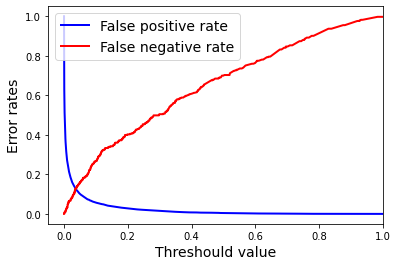

In [20]:
fpr, tpr, thrds = roc_curve(y, y_proba[:, 1])   # False/True possitive rates, and thresholds

plt.plot(thrds, fpr, 
         c='b', linewidth=2, 
         label='False positive rate')           # Plot the curve for false postive rate
plt.plot(thrds, 1-tpr,  
         c='r', linewidth=2, 
         label='False negative rate')           # Plot the curve for flase negative rate
plt.legend(fontsize=14, 
           loc='upper left')
plt.xlabel('Threshould value', fontsize=14)
plt.ylabel('Error rates', fontsize=14)
plt.xlim([-0.05, 1])
plt.show()

In the code segment above, the false/true positive rates and their corresponding threshold values are directly calculated by the function `roc_curve` imported from the `sklearn.metrics` package. Such a trade-off curve can also be visualized by the so called **ROC curve** (similar to Figure 4.8 in the reference book), or **receiver operating characteristics curve**, as a phrase coming from communication theory. 

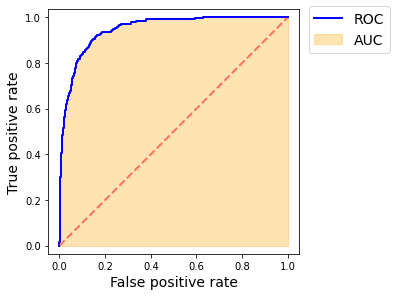

In [21]:
fpr, tpr, thrds = roc_curve(y, y_proba[:, 1])               # False/True possitive rates, and thresholds

plt.figure(figsize=(4.5, 4.5))
plt.fill_between(fpr, y1=0, y2=tpr, 
                 color='orange', alpha=0.3, label='AUC')    # Plot AUC
plt.plot(fpr, tpr, 
         c='b', linewidth=2, label='ROC')                   # Plot ROC
plt.plot([0, 1], [0, 1], 
         c='r', linewidth=2, alpha=0.5, linestyle='--')
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1.04))
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.axis('equal')
plt.show()

The **area under the (ROC) curve** is referred to as the AUC value, which indicates the overall performance of a model under all threshold values. The AUC value can be obtained by the function <code>auc()</code>, also imported from the <code>sklearn.metrics</code> package.

In [22]:
auc(fpr, tpr)

0.9478905822135366

The "best" threshold value for a classifier is usually determined in a case-by-case manner. One method is find the threshold value that maximizes the [Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic)

In [23]:
j_values = tpr - fpr                    # Youden's J statistic
thrd_best = thrds[np.argmax(j_values)]  # Best threshold from J statistic
thrd_best

0.03163468572645418

The confusion matrix for the new threshold value is given below. It can be seen that the prediction accuracy for the "default" cases is improved to nearly $90\%$, while the prediction accuracy for the "not default" cases drops to around $86\%$.

In [19]:
y_pred = (y_proba[:, 1] > thrd_best).astype(int)
confusion = confusion_matrix(y, y_pred, normalize='true')
pd.DataFrame(confusion, 
             index=['True not default', 'True default'], 
             columns=['Predicted not default', 'Predicted default'])

,Predicted not default,Predicted default
True not default,0.859005,0.140995
True default,0.102102,0.897898


In this section, only one predictor variable $x_{\text{balance}}$ is considered so that the model is simple enough to illustrate the basic concepts of logistic regression. In real applications, this approach and software tools can be easily extended to cases with multiple predictor variables.

Here, we also create a simulated dataset with different patterns such that
- There are two independent variables, $x_1$ and $x_2$;
- The response variable $y$ may belong to one of two classes;
- For both classes, 30 observations are randomly generated.

You may use the [Programming for Business Analytics](https://share.streamlit.io/xiongpengnus/learn_dao/main/web.py) website to explore how the logistic regression model can be used to fit the simulated datasets. The graph below shows an example of fitting well separated data using logistic regression.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/logreg_sep.png?raw=true" width=500>

Logistic regression models are typically used for the forecast of qualitative variables with two categories, though they have the potential to predict values with more than two classes. A few models that are more popular for multiple-class classifications are introduced in the next a few sections.

## Linear discriminant analysis <a id="section4"></a>

In this section, we will introduce a new method called linear discriminant analysis (LDA). It might outperform the logistic regression classifier under the following circumstances:
> - *When the classes are well-separated, the parameter estimates for the logistic regression model are surprisingly unstable. Linear discriminant analysis does not suffer from this problem.*
> - *If n is small and the distribution of the predictors X is approximately normal in each of the classes, the linear discriminant model is again more stable than the logistic regression model.*
> - *As mentioned in Section 4.3.5, linear discriminant analysis is popular
when we have more than two response classes.* - [An Introduction to Statistical Learning-with Applications in R](https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf))

Suppose that $\pmb{x}=(x_1, x_2, ..., x_p)$ is the vector of $p$ independent variables, and $y$ is the categorical response with $K$ classes. Let $f_K(\pmb{x})$ denote the density function of $x$ for an observation that comes from the $k$th class, then according to Bayes' Theorem we have

$$
p_k(\pmb{x}) = \frac{\pi_kf_k(\pmb{x})}{\sum_{l=1}^K\pi_l f_l(\pmb{x})},
$$

where $p_k(\pmb{x}) = \mathbb{P}(y=k|\pmb{x})$ denotes the *posterior* probability that an observation $\pmb{x}$ belongs to the $k$th class, and $\pi_k$ is the probability of response observations that belong to the $k$th class. Apparently, the response variable $y$ is predicted to be the $k$th class if $p_k(\pmb{x})$ is the largest among posterior probabilities of all $K$ classes. 

Estimating the density function $f_k(\pmb{x})$ is challenging, unless we assume some simple forms for the function, such as for the $k$th class, $\pmb{x}$ follows a multivariate Gaussian distribution $N(\pmb{\mu}_k, \pmb{\Sigma})$, $f_k(\pmb{x})$ can be hence written as

$$
f_k(\pmb{x}) = \frac{1}{(2\pi)^{p/2}|\pmb{\Sigma}|^{1/2}}\exp\left(-\frac{1}{2}(\pmb{x}-\pmb{\mu}_k)^{\top}\pmb{\Sigma}^{-1}(\pmb{x}-\pmb{\mu}_k)\right),
$$

where $\pmb{\mu}_k$ is the vector of mean values of $\pmb{x}$ belonging to the $k$th class, and $\pmb{\Sigma}$ is the covariance matrix of $\pmb{x}$ shared by all classes. 

By taking logarithm of the estimates of $\pi_kf_k(\pmb{x})$, it is easy to see that an observation $\pmb{x}$ belongs to the $k$th class if the following linear expression (thus the name **linear discriminant**)

$$
\delta_k(\pmb{x}) = \pmb{x}^{\top}\pmb{\Sigma}^{-1}\pmb{\mu}_k - \frac{1}{2}\pmb{\mu}_k^{\top}{\Sigma}^{-1}\pmb{\mu}_k + \log\left(\pi_k\right)
$$

is the largest. The linear function $\delta(\pmb{x})$ can be then used on a sample dataset by plugging estimates $\hat{\pi}_k$, $\hat{\pmb{\mu}}_k$ and $\hat{\pmb{\Sigma}}$ for parameters $\pi_k$, $\pmb{\mu}_k$, and $\pmb{\Sigma}$, respectively.


We could use the [Programming for Business Analytics](https://share.streamlit.io/xiongpengnus/learn_dao/main/web.py) website again to explore how the LDA is used to predict the class of the response variable $y$. The graph below shows an example of fitting well separated two classes using LDA.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/lda_pdf_sep.png?raw=true" width=500>

Note that in this example, the number of observations for each class is the same, so $\hat{\pi}_1=\hat{\pi}_2$ and it implies that the predicted classes are solely determined by the estimated density function $\hat{f}_k(\pmb{x})$ (shown by the dash lines). That is why the two classes are separated by a straight line where $\hat{f}_1(\pmb{x})=\hat{f}_2(\pmb{x})$. In cases that the sample size of each class is unequal, or $\hat{\pi}_1\not=\hat{\pi}_2$, we can prove that the discriminant function is still a straight line but is shifted by a distance determined by the ratio of $\hat{\pi}_1/\hat{\pi}_2$.

When different classes cannot be well separated by a linear discriminant function, the performance may not be as good as the well separated cases, as shown by the following examples.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/lda_pdf_nonsep.png?raw=true">

## Quadratic discriminant analysis <a id="section5"></a>

Recalling that in deriving the LDA method, a key assumption is that for the $k$ the class, variables $\pmb{x}$ follows a Gaussian distribution $N(\pmb{\mu}_k, \pmb{\Sigma})$. This is a rather strong assumption, especially considering that the covariance matrix $\pmb{\Sigma}$ is the same for all classes. An alternative method is to assume that each class of observations has a unique covariance matrix $\pmb{\Sigma}_k$, then the model determines the predicted class $k$ if the expression

$$
\delta_k(\pmb{x}) = -\frac{1}{2}\pmb{x}^{\top}\pmb{\Sigma}_k^{-1}\pmb{x} + \pmb{\mu}_k^{\top}\pmb{\Sigma}_k^{-1}\pmb{x} - \frac{1}{2}\pmb{\mu}_k^{\top}\pmb{\Sigma}^{-1}\pmb{\mu}_k -\frac{1}{2}\log\left(|\pmb{\Sigma}_k|\right) + \log\left(\pi_k\right)
$$

is the largest. Notice that the function $\delta_k(\pmb{x})$ is a quadratic function of $\pmb{x}$, so this method is called **quadratic discriminant analysis (QDA)**. 

Here, we could use the [Programming for Business Analytics](https://share.streamlit.io/xiongpengnus/learn_dao/main/web.py) website to study the intuition of the QDA method. We are particularly interested in the performance of QDA when it is applied to not well separated classes, and it is shown by the following figures, QDA outperforms LDA in predicting the response $y$.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/qda_pdf_nonsep.png?raw=true">

<div class="alert alert-block alert-success">
<b>Example 2:</b>  
    Consider the dataset "iris.csv" for classifying iris species based on their features such as sepal length, sepal width, petal length and petal width. Please use LDA and QDA methods to predict the iris species.
</div>

<img src="https://miro.medium.com/max/1000/1*Hh53mOF4Xy4eORjLilKOwA.png" width=500>

In [20]:
iris = pd.read_csv('iris.csv')
iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
...,...,...,...,...,...
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


The LDA and QDA models can be conveniently implemented by the `LinearDiscriminantAnalysis()` and `QuadraticDiscriminantAnalysis()` functions, imported from the `sklearn.discriminant_analysis` package.

In [21]:
lda = LinearDiscriminantAnalysis()
x = iris.drop(columns='Species')
y = iris['Species']

cv = ShuffleSplit(n_splits=4)  
cross_val_score(lda, x, y, cv=cv)

array([1.        , 1.        , 1.        , 0.93333333])

In [22]:
qda = QuadraticDiscriminantAnalysis()
x = iris.drop(columns='Species')
y = iris['Species']

cv = ShuffleSplit(n_splits=4)
cross_val_score(qda, x, y, cv=cv)

array([1.        , 0.93333333, 1.        , 1.        ])

It can be seen that LDA/QDA models perform extremely well in the iris classification problem, because these iris species can be easily separated by linear boundaries.

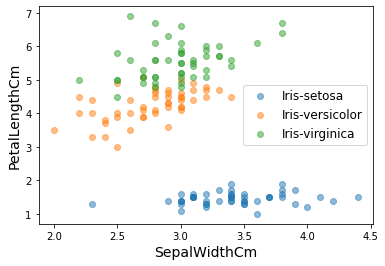

In [25]:
xlabel = 'SepalWidthCm'
ylabel = 'PetalLengthCm'

for species in iris['Species'].unique():
    subset = iris.loc[iris['Species'] == species]
    plt.scatter(subset[xlabel], subset[ylabel], alpha=0.5, label=species)

plt.legend(fontsize=12)
plt.xlabel(xlabel, fontsize=14)
plt.ylabel(ylabel, fontsize=14)
plt.show()

## Support vector machines <a id="section6"></a>

### Maximal margin classifier for well separated classes <a id="subsection6.1"></a>

Our discussion on support vector machines starts from a simple case such that:
1. There are $p$ independent variables, denoted by $\pmb{x}=(x_1, x_2, x_3, ..., x_p)$;
2. The response variable $y$ belongs to one of two classes, labeled by -1 and 1.
3. The dataset can be well separated by a **hyperplane**, expressed as $\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p = 0$.

The figure below shows a $p=2$ dimensional example of well separated sample data. 

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/data_sep.png?raw=true" width=360>

Our goal is to identify parameters of the hyperplane such that 

$$
\begin{cases}
\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p < 0, \text{ if }y=-1 \\
\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p > 0, \text{ if }y=1,
\end{cases}
$$

Apparently, there exits an infinite number of possible hyperplanes that satisfy the condition above, if two classes can be well separated. We therefore seek the hyperplane that maximizes the *margin* (indicated by the dash lines in the figure below) between two classes.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/maximal_margin_classifier.png?raw=true" width=500>

Such a predictive method is referred to as the **maximal margin classifier**, and parameters of the resultant hyperplane can be identified by solving the convex optimization problem 

$$
\begin{align}
\min ~&\|\pmb{\beta}\|^2 &&\\
\text{s.t.}~&y_i (\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + ...+\beta_px_{ip}) \geq 1 && i=1, 2, ..., n
\end{align}
$$

where the vector $\pmb{\beta}=(\beta_1, \beta_2, ..., \beta_p)$ and $n$ is the number of observations of the training dataset. Note that the notation $\|\cdot\|$ expresses the Euclidean norm, so the objective function is $\|\pmb{\beta}\|=\sqrt{\beta_1^2+\beta_2^2+...+\beta_p^2}$.

The convex optimization formulation above suggests that parameters of the hyperplane are solely determined by observations $\pmb{x}_i$ such that the constraints $y_i (\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + ...+\beta_px_{ip}) \geq 1$ are **active** (both sides of the constraints are equal). Such observations are referred to as **support vectors**, as highlighted by circles in the figure above. This observation implies that the maximal margin classifier are only affected by a number of support vectors that are close to the margin separating different classes. Other observations have no influence on the classifier.  

You may also notice that the convex optimization problem could be **infeasible**, meaning that no parameters $\beta_0$ and $\pmb{\beta}$ can satisfy all constraints. It happens when classes of data are not well separated, as the following cases.

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/data_nonsep.png?raw=true" width=850>

In the next subsection, we will discuss how to address such cases.

### Support vector classifier <a id="subsection6.2"></a>

Now we consider a modified method that allow constraints to be violated (meaning that some data points are located on the wrong side of the margin), and such violations are penalized by a regularization parameter $C$. Let $\xi_i$ denote the violation of the $i$th constraint, then the modified optimization problem can be written as

$$
\begin{align}
\min~&\frac{1}{2}\|\pmb{\beta}\|^2 + C\sum\limits_{i=1}^n\xi_i \\
\text{s.t.}~&y_i (\beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + ...+\beta_px_{ip}) \geq 1 - \xi_i,~\xi_i \geq 0.
\end{align}
$$

The following graphs show the results of applying this method to not well separated classes. 

<img src="https://github.com/XiongPengNUS/dao_resources/blob/main/svc_linear_overlap.png?raw=true">

### Support vector machine classifier <a id="subsection6.3"></a>

Given $(y_i, \pmb{x}_i)$ as a record of sample data, the separating hyperplane of the support vector classifier model can be written as

$$
\beta_0 + \sum\limits_{i=1}^n\alpha_iy_i\pmb{x}_i^{\top}\pmb{x} = 0
$$

where $\pmb{\alpha}=(\alpha_1, \alpha_2, ..., \alpha_n)$ is a vector of solution to the dual problem of the convex optimization formulation for the support vector classifier. Here, the inner product of $\pmb{x}_i$ and $\pmb{x}$ is defined to be a **kernel**, written as $K(\pmb{x}_i, \pmb{x})=\pmb{x}_i^{\top}\pmb{x}$, and in some textbooks, it is also written as $K(\pmb{x}_i, \pmb{x})=\langle\pmb{x}_i, \pmb{x}\rangle$. The kernel function in this case is a linear function of $\pmb{x}$, so it is called a **linear kernel**. 

Similar to regression models, besides considering the predictor variable $\pmb{x}$, features of $\pmb{x}$ can also be introduced to increase the flexibility of the model. Let $\pmb{h}(\pmb{x})$ denote the feature space of the predictor variables $\pmb{x}$, the kernel function is then $K(\pmb{x}_i, \pmb{x})=\pmb{h}(\pmb{x}_i)^{\top}\pmb{h}(\pmb{x})$.

> *What is the advantage of using a kernel rather than simply enlarging the feature space using functions of the original features, as in (9.16)? One advantage is computational, and it amounts to the fact that using kernels,
one need only compute $K(\pmb{x}_i, \pmb{x}_{i'})$ for all $\begin{pmatrix}n\\2\end{pmatrix}$ distinct pairs $i$, $i'$. This can be done without explicitly working in the enlarged feature space. This is important because in many applications of SVMs, the enlarged feature space is so large that computations are intractable. For some kernels, such as the radial kernel (9.24), the feature space is implicit and infinite-dimensional, so we could never do the computations there anyway!* - [An Introduction to Statistical Learning-with Applications in R](https://web.stanford.edu/~hastie/ISLRv2_website.pdf)

Commonly used kernel functions are
- Polynomial kernel: $K(\pmb{x}_i, \pmb{x})=\left(\pmb{x}_i^{\top}\pmb{x}+r\right)^d$. 
    - The degree $d$ of the polynomial kernel is specified by the keyword argument `degree`.
    - The constant coefficient $r$ in the expression is specified by the keyword argument `coef0`. Please note that in textbooks like [An Introduction to Statistical Learning-with Applications in R](https://web.stanford.edu/~hastie/ISLRv2_website.pdf), $r$ is fixed to be 1, but the `sklearn` package allows users to adjust this coefficient. 
- Radial basis function kernel: $K(\pmb{x}_i, \pmb{x})=\exp\left(-\gamma\|\pmb{x}_i - \pmb{x}\|^2\right)$
    - The non-negative parameter $\gamma$ is specified by the keyword argument `gamma`.
- Sigmoid (neural network) kernel: $K(\pmb{x}_i, \pmb{x})=\tanh\left(\gamma\pmb{x}_i^{\top}\pmb{x}+r\right)$
    - The constant coefficient $r$ in the expression is specified by the keyword argument `coef0`. 
    - The parameter $\gamma$ is specified by the keyword argument `gamma`.

The **support vector machine (SVM)** is an extension of the support vector classifier that results from enlarging the feature space using kernels. The SVM is very flexible in producing nonlinear separating boundaries for datasets that are non-separable by hyperplanes. You may use the [Programming for Business Analytics](https://share.streamlit.io/xiongpengnus/learn_dao/main/web.py) website to test SVMs with other types of kernels and parameters.

### SVMs with more than two classes

#### One-versus-one classification

Suppose there are $K$ classes for the response variable $y$, the **one-versus-one** or **all-pair** approach constructs $\begin{pmatrix}K\\2\end{pmatrix}$ SVMs and each SVM is used for the prediction between a pair of classes. The final classification is performed by assigning the test observation to the class to which it was most frequently assigned in these $\begin{pmatrix}K\\2\end{pmatrix}$ pairwise classifications.

#### One-versus-all classification
This method fits $K$ SVMs, and each time the prediction decision is made between one of the $K$ classes (coded as 1) and the remaining $K$ classes (code as -1). The final decision of an observation $\pmb{x}$ is class $k$ if the separating function $f_k(\pmb{x})$ of the $k$th SVM is the largest.

<div class="alert alert-block alert-success">
<b>Example 3:</b>  
    Consider the dataset "iris.csv" for classifying iris species based on their features such as sepal length, sepal width, petal length and petal width. Use SVM models to predict the iris species. You may try different types of kernels for the SVM model.
</div>

The following model applies the RBF kernel with the default parameters.

In [26]:
svm = SVC(C=10, kernel='rbf')
x = iris.drop(columns='Species')
y = iris['Species']

cv = ShuffleSplit(n_splits=4)
cross_val_score(svm, x, y, cv=cv)

array([1., 1., 1., 1.])

The default setting of `SVC` models uses the one-versus-all criterion (`decision_function_shape='ovr'`) to determine the predicted class. You could also try the one-versus-one criterion as the code segment below.

In [27]:
svm = SVC(C=10, kernel='rbf', decision_function_shape='ovo')
x = iris.drop(columns='Species')
y = iris['Species']

cv = ShuffleSplit(n_splits=4)
cross_val_score(svm, x, y, cv=cv)

array([0.93333333, 0.93333333, 1.        , 1.        ])

### $K$-nearest neighbor classification <a id="section7"></a>

Given a positive integer $K$ and a test observation $\pmb{x}$, the **$K$-nearest neighbor (KNN)** classifier first identifies the $K$ points in the training data that are closest to $\pmb{x}$. It then predict the class using majority vote among the $K$ neighbors. Unlike all aforementioned approaches, the KNN classifier is a **non-parametric** method, which does not explicitly assume a parametric form for $f(\pmb{x})$. 

<div class="alert alert-block alert-success">
<b>Example 4:</b>  
    Consider the dataset "iris.csv" for classifying iris species based on their features such as sepal length, sepal width, petal length and petal width. Use the KNN model (with different values of $K$) to predict the iris species.
</div>

In [28]:
steps = [
    ('scaler', MinMaxScaler()),                             # Step 1: Normalized scaler
    ('knn', KNeighborsClassifier(n_neighbors=5))            # Step 2: KNN
]                        
pipe = Pipeline(steps) 

x = iris.drop(columns='Species')
y = iris['Species']

cv = ShuffleSplit(n_splits=4)
cross_val_score(pipe, x, y, cv=cv)

array([1.        , 0.93333333, 1.        , 1.        ])

## Case studies <a id="section8"></a>

### Case study 1: Bank marketing <a id="subsection8.1"></a>

Please use the information provided in the dataset "bank.csv" to predict if the customer is likely to subscribed a term deposit (variable `subscribed`). Interpretation of each column of the dataset is given below.

- `age`: age of the customer.
- `job`: job of the customer.
- `marital`: marital status of the customer.
- `education`: education background of the customer.
- `default`: does the customer have credit in default.
- `balance`: balance of the customer's account.
- `housing`: does the customer have housing loan.
- `loan`: does the customer have any personal loan.
- `contact`: contact communication type of the customer.
- `campaign`: number of contacts with the customer performed during this campaign.
- `pdays`: number of days that passed by after the customer was last contacted from a previous campaign. (999 means that the customer was not previous contacted)
- `previous`: number of contacts performed before this campaign and for this customer.
- `poutcome`: outcome of the previous marketing campaign.
-  `subscribed`: has the customer subscribed a term deposit. This is considered the response of the predictive model.

In [3]:
bank = pd.read_csv('bank.csv')
bank

,age,job,marital,education,default,...,campaign,pdays,previous,poutcome,subscribed
0,30,unemployed,married,primary,no,...,1,900,0,unknown,no
1,33,services,married,secondary,no,...,1,339,4,failure,no
2,35,management,single,tertiary,no,...,1,330,1,failure,no
...,...,...,...,...,...,...,...,...,...,...,...
4518,57,technician,married,secondary,no,...,11,900,0,unknown,no
4519,28,blue-collar,married,secondary,no,...,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,...,2,249,7,other,no


In [5]:
steps = [
    ('scaler', MinMaxScaler()),                             # Step 1: Normalized scaler
    ('knn', KNeighborsClassifier(n_neighbors=5))            # Step 2: KNN
]                        
pipe = Pipeline(steps) 

x = bank.drop(columns='subscribed')
y = bank['subscribed']

cv = ShuffleSplit(n_splits=4)
cross_val_score(pipe, x, y, cv=cv)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File 

array([nan, nan, nan, nan])